In [1]:
import os, glob, numpy as np, csv, math
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from scipy import signal, fftpack
from matplotlib.legend_handler import HandlerLine2D
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


dir_path = os.path.dirname(os.path.realpath('ParallelPlates.ipynb'))
wrkdir = os.path.join(dir_path,'data')
csv_files = os.path.join(wrkdir,'*.csv')
meta_files = os.path.join(wrkdir,'*.txt')
trackdata = glob.glob(csv_files)
metadata = glob.glob(meta_files)
n_files = np.size(trackdata)

def get_variables(metadata):
    f = open(metadata[0],"r")
    drop_vars = list(csv.reader(f))
    f.close()
    
    
    drop_meta = {}
    for i in range(n_files):
        drop_meta[drop_vars[i+1][0]] = {}
        n_meta = np.size(drop_vars[0][1:])
        for n in range(n_meta):
            drop_meta[drop_vars[i+1][0]][drop_vars[0][n+1].split('_')[0]] = float(drop_vars[i+1][n+1])

    meta = drop_meta
    return meta

meta = get_variables(metadata)

def get_data(wrkdir,csv_files,trackdata,n_files):
    
    total_drop_data = {}
    
    
    for i in range(n_files):
        (location, name) = os.path.split( trackdata[i] )
        
        f = open(trackdata[i],"r")
        drop_data = list(csv.reader(f))
        f.close()
        
        col_names = drop_data[0]
        n_col = np.size(drop_data[0])
        drop_data = np.asarray(drop_data[1:],dtype=float)
        total_drop_data[name[:-4]] = {}
        for j in range(n_col):
            total_drop_data[name[:-4]][col_names[j]] = drop_data[:,j]

    return total_drop_data

data = get_data(wrkdir,csv_files,trackdata,n_files)

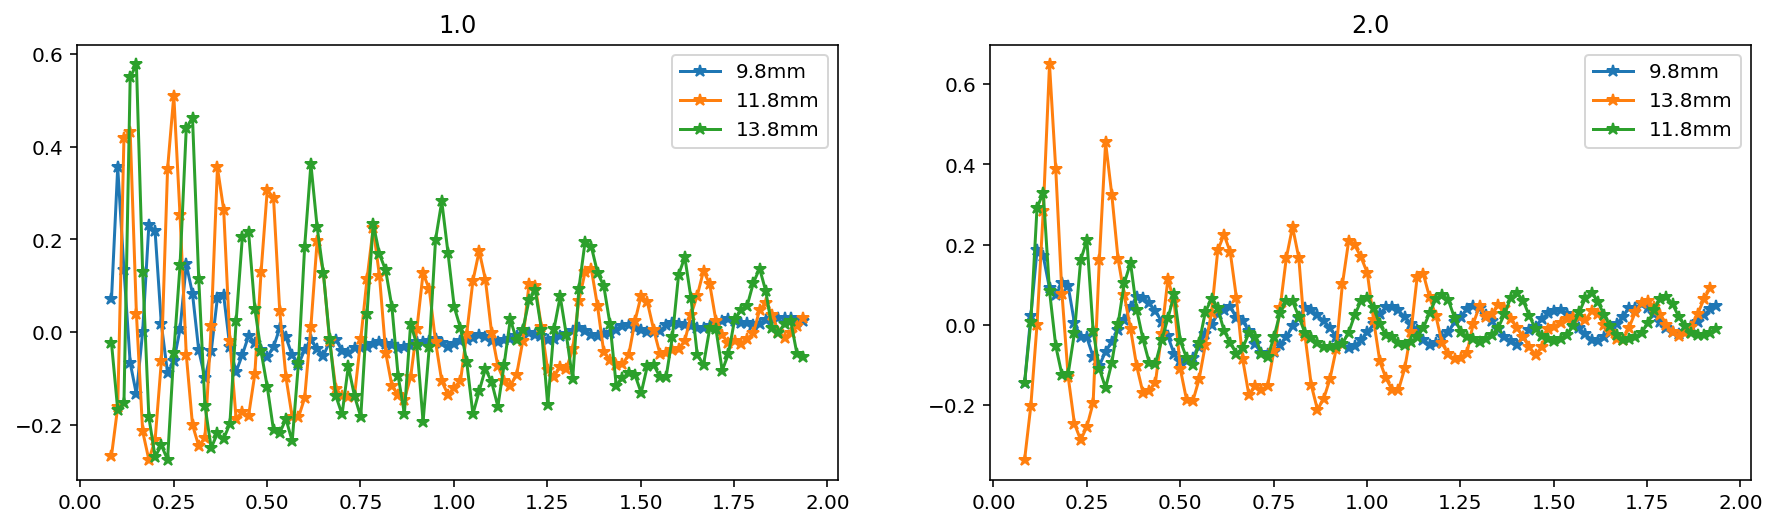

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


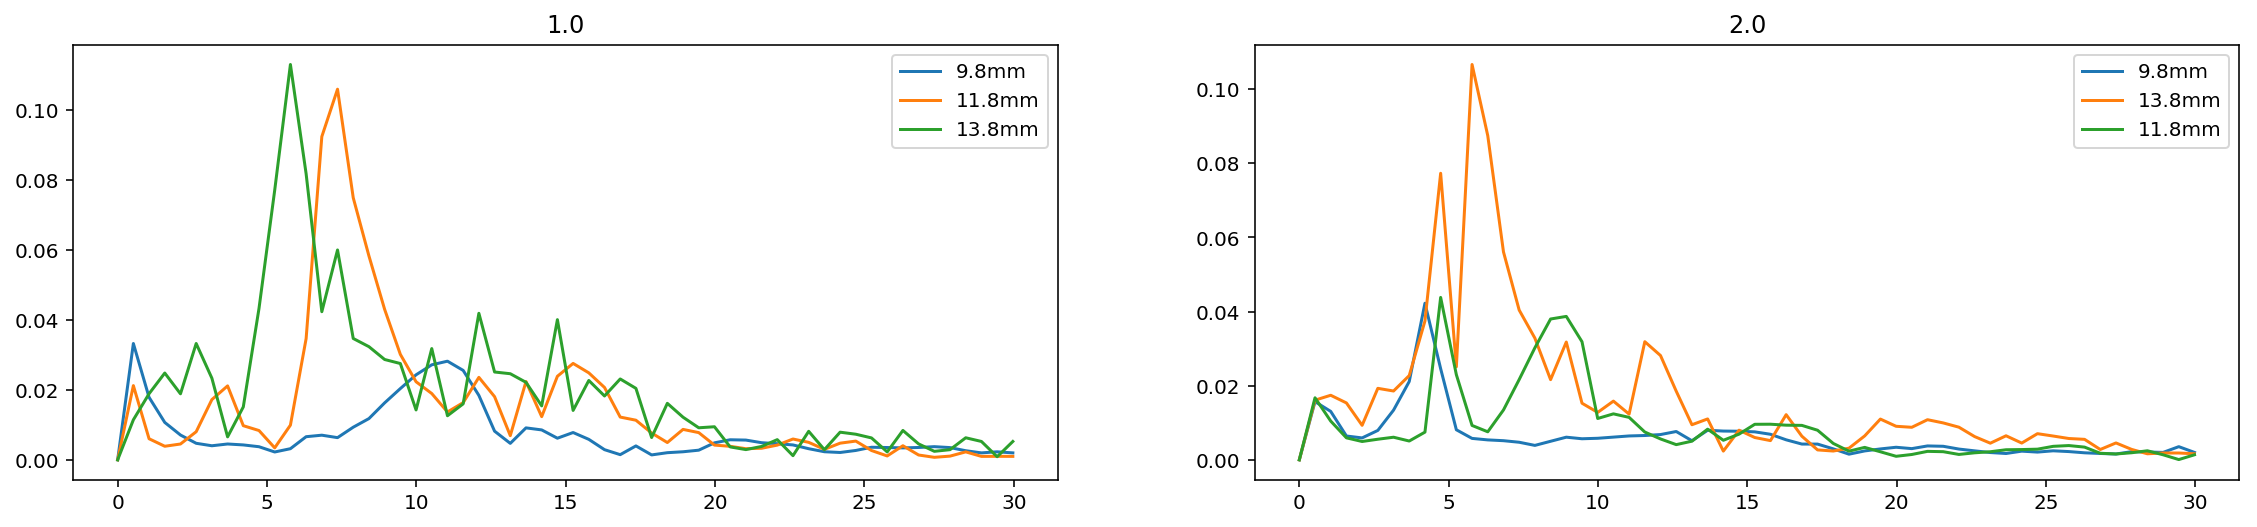

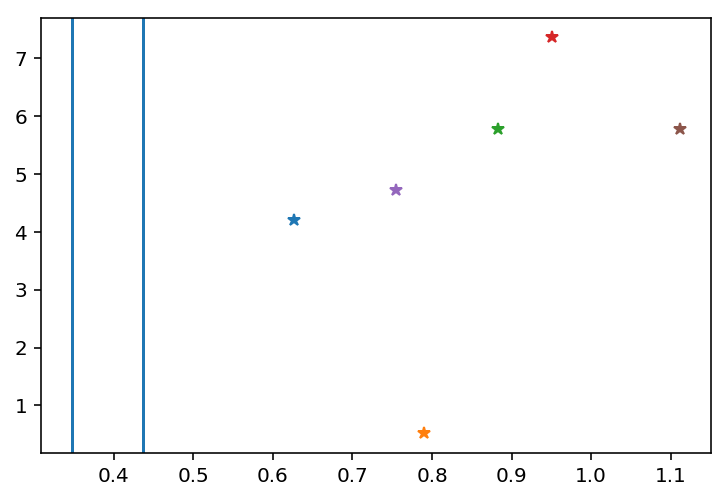

In [7]:
AR = {}
t = {}
for key in data:
    AR[key] = data[key]['AR']
    t[key] = (data[key]['Slice']-1)/59.94
    
from scipy.signal import find_peaks_cwt

peaks = {}
peaktimes = {}
for key in data:
    indx_peaks = signal.find_peaks_cwt(AR[key],np.arange(1,5))
    
    peaks[key] = AR[key][indx_peaks]
    peaktimes[key] = t[key][indx_peaks]
    
def plot_raw(t,AR):
    fig = plt.figure(facecolor='white')
    fig.set_figwidth(30)
    fig.set_figwidth(15)
    for key in AR:
        N = int(np.size(t[key]))
        T = t[key][1]-t[key][0]
        m,b = np.polyfit(t[key][5:], AR[key][5:], 1)
        AR_filt = np.zeros(N-5)
        for i in range(N-5):
            AR_filt[i] = AR[key][i+5] - (m*t[key][i+5]+b) 
        if meta[key]['volume']==1.0:
            ax = fig.add_subplot(1,2,1)
            ax.plot(t[key][5:],AR_filt,'-*',label=str(meta[key]['height'])+'mm')
            #ax.plot(peaktimes[key],peaks[key],'.')
            plt.title(str(meta[key]['volume']))
        elif meta[key]['volume']==2.0:
            ax = fig.add_subplot(1,2,2)
            ax.plot(t[key][5:],AR_filt,'-*',label=str(meta[key]['height'])+'mm')
            #ax.plot(peaktimes[key],peaks[key],'.')
            plt.title(str(meta[key]['volume']))
        plt.legend()
    plt.show()
plot_raw(t,AR)

def fastfourier(t,AR):
    import scipy.fftpack
    fig = plt.figure(facecolor='white')
    fig.set_figwidth(30)
    fig.set_figwidth(30)
    damp_freq = {}
    for key in AR:
        
        N = int(np.size(t[key]))
        T = t[key][1]-t[key][0]
        m,b = np.polyfit(t[key][5:], AR[key][5:], 1)
        AR_filt = np.zeros(N-5)
        
        for i in range(N-5):
            AR_filt[i] = AR[key][i+5] - (m*t[key][i+5]+b)            
        
        yf = scipy.fftpack.fft(AR_filt)
        xf = np.linspace(0.0, 1.0/(2.0*T), N/2)
        idx = np.where(2.0/N * np.abs(yf[:N//2])==np.max(2.0/N * np.abs(yf[:N//2])))
        damp_freq[key] = xf[idx]
        if meta[key]['volume']==1.0:
            ax = fig.add_subplot(1,3,1)
            ax.plot(xf, 2.0/N * np.abs(yf[:N//2]),label=str(meta[key]['height'])+'mm')
            plt.title(str(meta[key]['volume']))
        elif meta[key]['volume']==2.0:
            ax = fig.add_subplot(1,3,2)
            ax.plot(xf, 2.0/N * np.abs(yf[:N//2]),label=str(meta[key]['height'])+'mm')
            plt.title(str(meta[key]['volume']))
        plt.legend()
    plt.show()
    
    for key in damp_freq:
        drop_d = 2*((3000*meta[key]['volume'])/(4*math.pi))**(1/3)
        plt.plot(meta[key]['height']/drop_d,damp_freq[key],'*')
        plt.axvline(5.42/drop_d)
    plt.show()
fastfourier(t,AR)